In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# load mbti_1_cleaned.csv
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/MBTI/mbti_1_cleaned.csv')
if isinstance(df.y_encoded.values[1],str):
    df['y_encoded'] = df['y_encoded'].apply(lambda x: eval(x))
df.head()

,type,posts,cleaned_posts,average_word_counts,average_word_length,average_emo_score,y_encoded
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,and moments sportscenter not top ten play...,12.10,6.492562,0.133946,"[1.0, 1.0, -1.0, -1.0]"
1,ENTP,'I'm finding the lack of me in these posts ver...,Im finding the lack of me in these posts very ...,24.38,4.686628,0.177719,"[-1.0, 1.0, 1.0, 1.0]"
2,INTP,'Good one _____ https://www.youtube.com/wat...,Good one course to which I say I know tha...,17.70,4.802260,0.167841,"[1.0, 1.0, 1.0, 1.0]"
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",Dear I enjoyed our conversation the other d...,22.26,4.513926,0.118772,"[1.0, 1.0, 1.0, -1.0]"
4,ENTJ,'You're fired.|||That's another silly misconce...,Youre firedThats another silly misconception T...,20.32,4.899606,0.059798,"[-1.0, 1.0, 1.0, -1.0]"


In [ ]:
# view the distribution of average word length of each personality type
# also average_word_count, average_emo_score
# import matplotlib.pyplot as plt
# import seaborn as sns
# sns.set()
# plt.figure(figsize=(12,6))
# sns.boxplot(x='type', y='average_word_length', data=df)
# plt.title('Average Word Length Distribution')
# plt.show()
# sns.set()
# plt.figure(figsize=(12,6))
# sns.boxplot(x='type', y='average_word_counts', data=df)
# plt.title('Average Word Count Distribution')
# plt.show()
# plt.figure(figsize=(12,6))
# sns.boxplot(x='type', y='average_emo_score', data=df)
# plt.title('Average Emotion Score Distribution')
# plt.show()

In [ ]:
# view the distribution of average word length for I/E, N/S, T/F, J/P
# plt.figure(figsize=(12,6))
# df['I/E'] = df['type'].apply(lambda x: x[0])
# sns.boxplot(x='I/E', y='average_emo_score', data=df)
# plt.title('Average Word Length Distribution for I/E')
# plt.show()
# plt.figure(figsize=(12,6))
# df['N/S'] = df['type'].apply(lambda x: x[1])
# sns.boxplot(x='N/S', y='average_emo_score', data=df)
# plt.title('Average Word Length Distribution for N/S')
# plt.show()
# plt.figure(figsize=(12,6))
# df['T/F'] = df['type'].apply(lambda x: x[2])
# sns.boxplot(x='T/F', y='average_emo_score', data=df)
# plt.title('Average Word Length Distribution for T/F')
# plt.show()
# plt.figure(figsize=(12,6))
# df['J/P'] = df['type'].apply(lambda x: x[3])
# sns.boxplot(x='J/P', y='average_emo_score', data=df)
# plt.title('Average Word Length Distribution for J/P')
# plt.show()

In [ ]:
# train a word2vec model
import gensim
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
import re
x = df['cleaned_posts'].values
sentences = [sentence.split() for sentence in x]  # split each sentence into a list of words
w2v_model = gensim.models.Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)
# w2v_model.save('../model/w2v.model')

In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/MBTI')
from utilities import *
# load the word2vec model
DATA_PATH = '../data/mbti_1_cleaned.csv'
df_train, df_test = split_data(df)
# w2v_model = gensim.models.Word2Vec.load('/content/drive/MyDrive/PAI_data')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# use the word2vec model to get the average word vector for each post
# and get the average word vector for each personality type
# and use cosine similarity to find the most similar personality type
import nltk
nltk.download('punkt')
def get_average_word_vector(model, sentence):
    word_tokens = word_tokenize(sentence)
    # remove words that are not in the vocabulary
    filtered_sentence = [w for w in word_tokens if w in model.wv.key_to_index]
    # get the average word vector
    average_vector = np.zeros((model.vector_size,))
    for word in filtered_sentence:
        average_vector += model.wv[word]
    average_vector /= len(filtered_sentence)
    return average_vector
x_train = df_train['cleaned_posts'].values
x_test = df_test['cleaned_posts'].values
# get the average word vector for each post
x_train_average_word_vector = []
for sentence in x_train:
    x_train_average_word_vector.append(get_average_word_vector(w2v_model, sentence))
x_test_average_word_vector = []
for sentence in x_test:
    x_test_average_word_vector.append(get_average_word_vector(w2v_model, sentence))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
# save x_train_average_word_vector and x_test_average_word_vector
# import pickle
# with open('../data/x_train_average_word_vector.pkl', 'wb') as f:
#     pickle.dump(x_train_average_word_vector, f)
# with open('../data/x_test_average_word_vector.pkl', 'wb') as f:
#     pickle.dump(x_test_average_word_vector, f)

In [ ]:
def balance_data(X_train, y_train):
    from imblearn.over_sampling import SMOTE
    from collections import Counter
    sm = SMOTE(random_state=42)
    print('Original dataset shape %s' % Counter(y_train))
    X_train, y_train = sm.fit_resample(X_train, y_train)
    print('Resampled dataset shape %s' % Counter(y_train))
    return X_train, y_train

def train_model_balence(X_train, y_train, X_test, y_test, models):
    from sklearn.metrics import accuracy_score, classification_report
    for i,model in enumerate(models):
        X_train_balenced, y_train_balenced = balance_data(X_train, y_train[:,i])
        model.fit(X_train_balenced, y_train_balenced)
        y_pred = model.predict(X_test)
        print("Accuracy for dimension {} is {}".format(i, accuracy_score(y_test[:,i], y_pred)))
        print(classification_report(y_test[:,i], y_pred))
        print("\n")

In [ ]:
x_train_average_word_vector = np.array(x_train_average_word_vector)
x_test_average_word_vector = np.array(x_test_average_word_vector)

In [ ]:
!pip install --upgrade setuptools
!pip install ez_setup
!easy_install -U setuptools
!pip install pipelinehelper

/bin/bash: line 1: easy_install: command not found
  Using cached pipelinehelper-0.7.8-py3-none-any.whl (15 kB)
  Using cached sklearn-0.0.post10.tar.gz (3.6 kB)
  Preparing metadata (setup.py) ... done
  Created wheel for sklearn: filename=sklearn-0.0.post10-py3-none-any.whl size=2959 sha256=5a6d9180a84eaa1ad004e28e58e1bcc3f9f1216923608d63aee9e56b9967411e
  Stored in directory: /root/.cache/pip/wheels/5b/f6/92/0173054cc528db7ffe7b0c7652a96c3102aab156a6da960387
Successfully built sklearn


In [ ]:
# use grid search to find best model for each dimension
# and find the best hyperparameters for each model
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from pipelinehelper import PipelineHelper
from sklearn.preprocessing import StandardScaler, MaxAbsScaler
pipe = Pipeline([
    ('classifier', PipelineHelper([
    ('svc', SVC()),
    ('lr', LogisticRegression()),
    ('nb', GaussianNB()),
    ('xgb', XGBClassifier())
]))])
params = {

    'classifier__selected_model': pipe.named_steps['classifier'].generate({
        'svc__C': [ 10, 100, 500],
        'lr__C': [ 10, 100, 500],
        'nb__var_smoothing': [1e-9, 1e-8, 1e-7],
        'xgb__lambda': [10, 100, 500]
    })
}
def train_model(X_train, y_train, X_test, y_test, model, params):

    grid_search = GridSearchCV(model, params, cv=5, scoring='f1', n_jobs=-1)
    # balance the data
    X_train_balenced, y_train_balenced = balance_data(X_train, y_train)
    grid_search.fit(X_train_balenced, y_train_balenced)
    print(grid_search.best_params_)
    y_pred = grid_search.predict(X_test)
    print("Accuracy is {}".format(accuracy_score(y_test, y_pred)))
    print(classification_report(y_test, y_pred))
    print("\n")
    return grid_search

y_train_01 = y_train.copy()
y_train_01[y_train_01 == -1] = 0
y_test_01 = y_test.copy()
y_test_01[y_test_01 == -1] = 0

x_train_all_features = np.column_stack((x_train_average_word_vector, df_train[['average_word_length', 'average_word_counts', 'average_emo_score']].values))
x_test_all_features = np.column_stack((x_test_average_word_vector, df_test[['average_word_length', 'average_word_counts', 'average_emo_score']].values))

# apply grid search to each dimension
grid_search_results = []
for i in range(4):
    print("Dimension {}".format(i))
    g_s = train_model(x_train_all_features, y_train_01[:,i], x_test_all_features, y_test_01[:,i], pipe, params)
    grid_search_results.append(g_s)

Dimension 0
Original dataset shape Counter({1.0: 5326, 0.0: 1614})
Resampled dataset shape Counter({1.0: 5326, 0.0: 5326})
{'classifier__selected_model': ('xgb', {'lambda': 10})}
Accuracy is 0.7187319884726224
              precision    recall  f1-score   support

         0.0       0.37      0.39      0.38       385
         1.0       0.82      0.81      0.82      1350

    accuracy                           0.72      1735
   macro avg       0.60      0.60      0.60      1735
weighted avg       0.72      0.72      0.72      1735



Dimension 1
Original dataset shape Counter({1.0: 6001, 0.0: 939})
Resampled dataset shape Counter({0.0: 6001, 1.0: 6001})
{'classifier__selected_model': ('xgb', {'lambda': 10})}
Accuracy is 0.7821325648414985
              precision    recall  f1-score   support

         0.0       0.23      0.20      0.21       258
         1.0       0.86      0.88      0.87      1477

    accuracy                           0.78      1735
   macro avg       0.55      0.54 

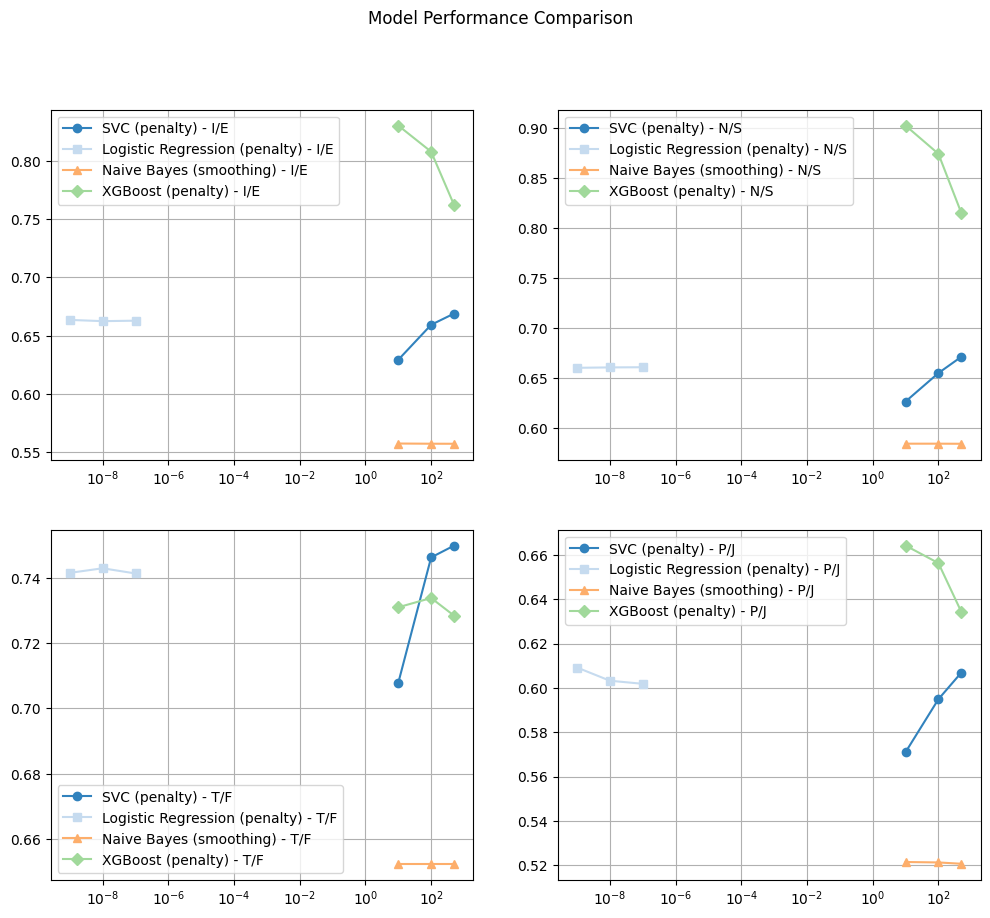

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
def plot_scores_by_model_and_params(dataset_results, dataset_labels):
    models = ["SVC (penalty)", "Logistic Regression (penalty)", "Naive Bayes (smoothing)", "XGBoost (penalty)"]
    param_values = [10, 100, 500, 1e-09, 1e-08, 1e-07, 10, 100, 500, 10, 100, 500]

    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    fig.suptitle('Model Performance Comparison')

    colors = cm.tab20c(np.linspace(0, 0.5, len(models)))
    markers = ['o', 's', '^', 'D']

    for i, dataset in enumerate(dataset_results):
        ax = axes[i // 2, i % 2]
        ax.set_xscale('log')

        for j, model in enumerate(models):
            param_num = 3
            offset = j * param_num
            scores = dataset.cv_results_['mean_test_score'][offset:offset + param_num]
            param_values_i = param_values[offset:offset + param_num]

            if dataset_labels:
                label = f"{model} - {dataset_labels[i]}"
            else:
                label = model

            ax.plot(param_values_i, scores, marker=markers[j], c=colors[j], label=label)

        ax.grid(True)
        ax.legend(loc='best')

    plt.show()
plot_scores_by_model_and_params(grid_search_results,["I/E","N/S","T/F","P/J"])